In [8]:
import numpy as np  
import matplotlib.pyplot as plt
import gendata
import torch
from models.wdgrl_model import *
from tqdm.auto import trange

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
def clustering(
        X, 
        n_cluster: int = 3):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    labels = kmeans.fit_predict(X)
    return labels, kmeans

## Gen data

In [10]:
ns, nt, d = 2000, 100, 16

In [11]:
Xs, Ys, Xt, Yt, info = gendata.gen_domain_adaptation_data(
    n_source=ns,
    n_target=nt,
    n_features=d,
    n_clusters=3,
    domain_shift_type="covariate",
    shift_magnitude=2.0,  # Moderate shift
    noise_ratio=0.0,
    random_state=2043401597,
    base_center = (-3,3),
    cluster_std_source = 2,
    cluster_std_target = 2,
)

Fixed andom seed = 2043401597


In [12]:
Xs

array([[ 3.17182405, -0.26782458,  1.03120631, ...,  2.56484768,
         3.6277221 ,  2.17963371],
       [-4.83223417, -3.70120525, -0.63331494, ...,  2.66005045,
         1.6284218 , -0.80568533],
       [ 1.07975482,  4.73950022, -1.23364607, ..., -0.23479439,
         2.53756492,  0.43644071],
       ...,
       [-0.16190194, -6.50215445,  2.6156965 , ...,  3.11390482,
         2.27514261,  1.20202629],
       [-4.93427822, -2.35100813,  3.24211941, ...,  3.71983512,
         0.60872404, -0.10661262],
       [ 2.50813783,  0.47750797, -1.09938001, ..., -2.28225937,
        -0.25371512,  1.97910094]], shape=(2000, 16))

## TSNE 2d plot

Running t-SNE dimensionality reduction...


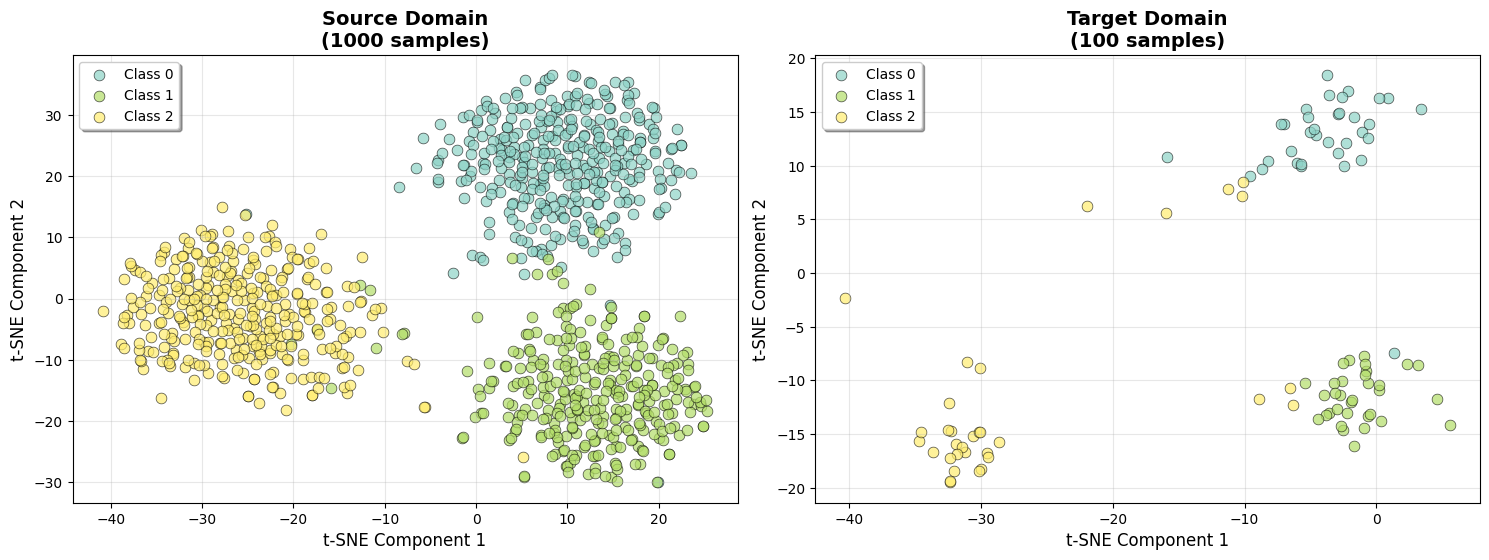

In [13]:
gendata.visualby_tsne(Xs,Xt,Ys,Yt)

## Original clustering

In [14]:

cluster_labels, model1 = clustering(Xt)

ari = adjusted_rand_score(Yt, cluster_labels)
print(f'Adjusted Rand Index (ARI) only on target domain: {ari:.4f}')

Adjusted Rand Index (ARI) only on target domain: 0.9697


___

In [15]:
xs = torch.from_numpy(Xs).float()
ys = torch.from_numpy(Ys).long()
xt = torch.from_numpy(Xt).float()
yt = torch.from_numpy(Yt).long()

In [16]:
from torch.utils.data import DataLoader, TensorDataset

source_dataset = TensorDataset(xs)
target_dataset = TensorDataset(xt)



## WDGRL

In [17]:
encoder_hidden_dims = [32]
critic_hidden_dims = [10,10]
model = WDGRL(
    input_dim=d, 
    encoder_hidden_dims=encoder_hidden_dims,
    critic_hidden_dims=critic_hidden_dims,
    _lr_encoder = 1e-3,
    _lr_critic = 1e-3,
    seed=42)
model.encoder = model.encoder.float()
model.critic = model.critic.float()

losses, source_critic_scores, target_critic_scores = model.train(
    source_dataset, 
    target_dataset,
    num_epochs=200,
    gamma=1,
    dc_iter= 10,
    batch_size=32)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]c:\Users\Asus\anaconda3\envs\dann\Lib\site-packages\torch\autograd\graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch: 100%|██████████| 200/200 [00:07<00:00, 26.83it/s]


In [18]:
xs_hat = model.extract_feature(xs.cuda())
xt_hat = model.extract_feature(xt.cuda())
xs_hat = xs_hat.cpu().numpy()
xt_hat = xt_hat.cpu().numpy()
print(xs_hat.shape)
print(xt_hat.shape)

(2000, 32)
(100, 32)


In [19]:
x_comb = np.vstack((xs_hat, xt_hat))
comb_cluster_labels, model2 = clustering(x_comb)
ari = adjusted_rand_score(Yt, comb_cluster_labels[ns:])
print(f'Adjusted Rand Index (ARI) of target on transported domain: {ari:.4f}')

Adjusted Rand Index (ARI) of target on transported domain: 0.8247


Running t-SNE dimensionality reduction...


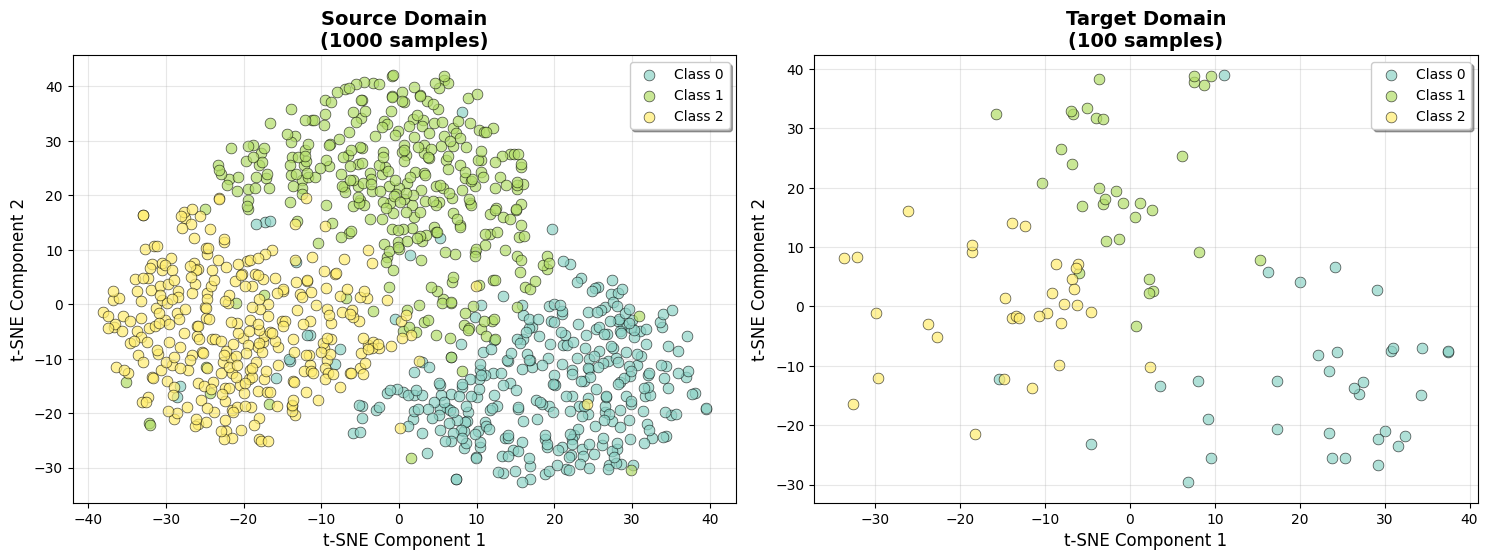

In [20]:
gendata.visualby_tsne(xs_hat, xt_hat, Ys, Yt)

## Fine-tune hyperparams

In [21]:
n_source_small = 1000
n_target_small = 80

# Randomly pick indices without replacement
src_indices = torch.randperm(len(xs))[:n_source_small]
tgt_indices = torch.randperm(len(xt))[:n_target_small]

# Create smaller tensors
xs_small = xs[src_indices]
xt_small = xt[tgt_indices]

# Subset labels (Ys, Yt are numpy arrays)
Ys_small = Ys[src_indices.cpu().numpy()]
Yt_small = Yt[tgt_indices.cpu().numpy()]

# Create smaller datasets
source_dataset_small = TensorDataset(xs_small)
target_dataset_small = TensorDataset(xt_small)

In [22]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [23]:
import numpy as np
from sklearn.metrics import adjusted_rand_score

def objective(trial):
    # Hyperparameter search space
    # encoder_hidden_dims = trial.suggest_categorical("encoder_hidden_dims", [[32], [10,10], [32,16]])
    # critic_hidden_dims  = trial.suggest_categorical("critic_hidden_dims", [[10, 10], [32,16], [32]])
    
    n_encoder_layers = trial.suggest_int("n_encoder_layers", 1, 3)
    encoder_hidden_dims = []
    for i in range(n_encoder_layers):
        # Suggest the number of nodes for each encoder layer
        dim = trial.suggest_int(f"encoder_dim_l{i}", 8, 64, log=True)
        encoder_hidden_dims.append(dim)
    # This is the line you need to add for the encoder
    trial.set_user_attr("encoder_hidden_dims", encoder_hidden_dims)
    

    # --- Critic Architecture Tuning ---
    # Suggest the number of hidden layers for the critic
    n_critic_layers = trial.suggest_int("n_critic_layers", 1, 3)
    critic_hidden_dims = []
    for i in range(n_critic_layers):
        # Suggest the number of nodes for each critic layer
        dim = trial.suggest_int(f"critic_dim_l{i}", 8, 64, log=True)
        critic_hidden_dims.append(dim)
    # This is the line you need to add for the critic
    trial.set_user_attr("critic_hidden_dims", critic_hidden_dims)


    lr_encoder = trial.suggest_float("_lr_encoder", 1e-4, 1e-3, log=True)
    lr_critic  = trial.suggest_float("_lr_critic", 1e-4, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 0.01, 10.0)
    dc_iter = trial.suggest_int("dc_iter", 5, 20)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Build WDGRL model
    model = WDGRL(
        input_dim=d,
        encoder_hidden_dims=encoder_hidden_dims,
        critic_hidden_dims=critic_hidden_dims,
        _lr_encoder=lr_encoder,
        _lr_critic=lr_critic,
        seed=42
    )
    model.encoder = model.encoder.float()
    model.critic = model.critic.float()

    # Train (shorter epochs for tuning)
    model.train(
        source_dataset_small, 
        target_dataset_small,
        num_epochs=50,
        gamma=gamma,
        dc_iter=dc_iter,
        batch_size=batch_size
    )

    xs_small_hat = model.extract_feature(xs_small.cuda())
    xt_small_hat = model.extract_feature(xt_small.cuda())
    xs_small_hat = xs_small_hat.cpu().numpy()
    xt_small_hat = xt_small_hat.cpu().numpy()
    
    # Combine and cluster
    x_small_comb = np.vstack((xs_small_hat, xt_small_hat))
    comb_sm_cluster_labels, _ = clustering(x_small_comb)

    # Compute ARI on transported target domain
    ari = adjusted_rand_score(Yt_small, comb_sm_cluster_labels[len(xs_small_hat):])
    return ari  # Optuna will maximize this


In [24]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print("Best params:", study.best_params)
print("Best ARI:", study.best_value)

[I 2025-08-10 15:47:40,788] A new study created in memory with name: no-name-8691ce05-78a2-4ebc-babb-7ff068cf783a
Epoch: 100%|██████████| 50/50 [00:01<00:00, 49.60it/s]
[I 2025-08-10 15:47:41,819] Trial 0 finished with value: 0.5145409220417579 and parameters: {'n_encoder_layers': 1, 'encoder_dim_l0': 40, 'n_critic_layers': 2, 'critic_dim_l0': 24, 'critic_dim_l1': 17, '_lr_encoder': 0.00016525468116385315, '_lr_critic': 0.00012882081397565075, 'gamma': 7.87272658326885, 'dc_iter': 6, 'batch_size': 64}. Best is trial 0 with value: 0.5145409220417579.
Epoch: 100%|██████████| 50/50 [00:02<00:00, 19.95it/s]
[I 2025-08-10 15:47:44,341] Trial 1 finished with value: 0.14244895702244625 and parameters: {'n_encoder_layers': 1, 'encoder_dim_l0': 12, 'n_critic_layers': 2, 'critic_dim_l0': 14, 'critic_dim_l1': 9, '_lr_encoder': 0.00010083407353634558, '_lr_critic': 0.0004023703767437486, 'gamma': 0.634568023996678, 'dc_iter': 16, 'batch_size': 16}. Best is trial 0 with value: 0.5145409220417579.
E

Best params: {'n_encoder_layers': 1, 'encoder_dim_l0': 53, 'n_critic_layers': 3, 'critic_dim_l0': 16, 'critic_dim_l1': 31, 'critic_dim_l2': 9, '_lr_encoder': 0.0005607736764153828, '_lr_critic': 0.0005426756066309247, 'gamma': 3.858582212777746, 'dc_iter': 7, 'batch_size': 32}
Best ARI: 0.8935113481747388


In [25]:
print(study.best_params)

{'n_encoder_layers': 1, 'encoder_dim_l0': 53, 'n_critic_layers': 3, 'critic_dim_l0': 16, 'critic_dim_l1': 31, 'critic_dim_l2': 9, '_lr_encoder': 0.0005607736764153828, '_lr_critic': 0.0005426756066309247, 'gamma': 3.858582212777746, 'dc_iter': 7, 'batch_size': 32}


In [26]:
# Assuming 'study' is your Optuna study object after optimization
best_trial = study.best_trial

print("Best Trial:")
print(f"  Value: {best_trial.value}")

print("\n  Directly Suggested Parameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

print("\n  Dynamically Generated Architecture (User Attributes):")
for key, value in best_trial.user_attrs.items():
    print(f"    {key}: {value}")

Best Trial:
  Value: 0.8935113481747388

  Directly Suggested Parameters:
    n_encoder_layers: 1
    encoder_dim_l0: 53
    n_critic_layers: 3
    critic_dim_l0: 16
    critic_dim_l1: 31
    critic_dim_l2: 9
    _lr_encoder: 0.0005607736764153828
    _lr_critic: 0.0005426756066309247
    gamma: 3.858582212777746
    dc_iter: 7
    batch_size: 32

  Dynamically Generated Architecture (User Attributes):
    encoder_hidden_dims: [53]
    critic_hidden_dims: [16, 31, 9]


In [27]:
best_trial.user_attrs["critic_hidden_dims"]

[16, 31, 9]

In [28]:
best_params = study.best_params

final_model = WDGRL(
    input_dim=d,
    encoder_hidden_dims=best_trial.user_attrs["encoder_hidden_dims"],
    critic_hidden_dims=best_trial.user_attrs["critic_hidden_dims"],
    _lr_encoder=best_params["_lr_encoder"],
    _lr_critic=best_params["_lr_critic"],
    seed=42
)
final_model.encoder = final_model.encoder.float()
final_model.critic = final_model.critic.float()

# Train longer for final fit
final_model.train(
    source_dataset,
    target_dataset,
    num_epochs=200,  # more epochs for final training
    gamma=best_params["gamma"],
    dc_iter=best_params["dc_iter"],
    batch_size=best_params["batch_size"]
)

Epoch: 100%|██████████| 200/200 [00:05<00:00, 34.59it/s]


([], [], [])

In [29]:
xs_hat = final_model.extract_feature(xs.cuda())
xt_hat = final_model.extract_feature(xt.cuda())
xs_hat = xs_hat.cpu().numpy()
xt_hat = xt_hat.cpu().numpy()

Running t-SNE dimensionality reduction...


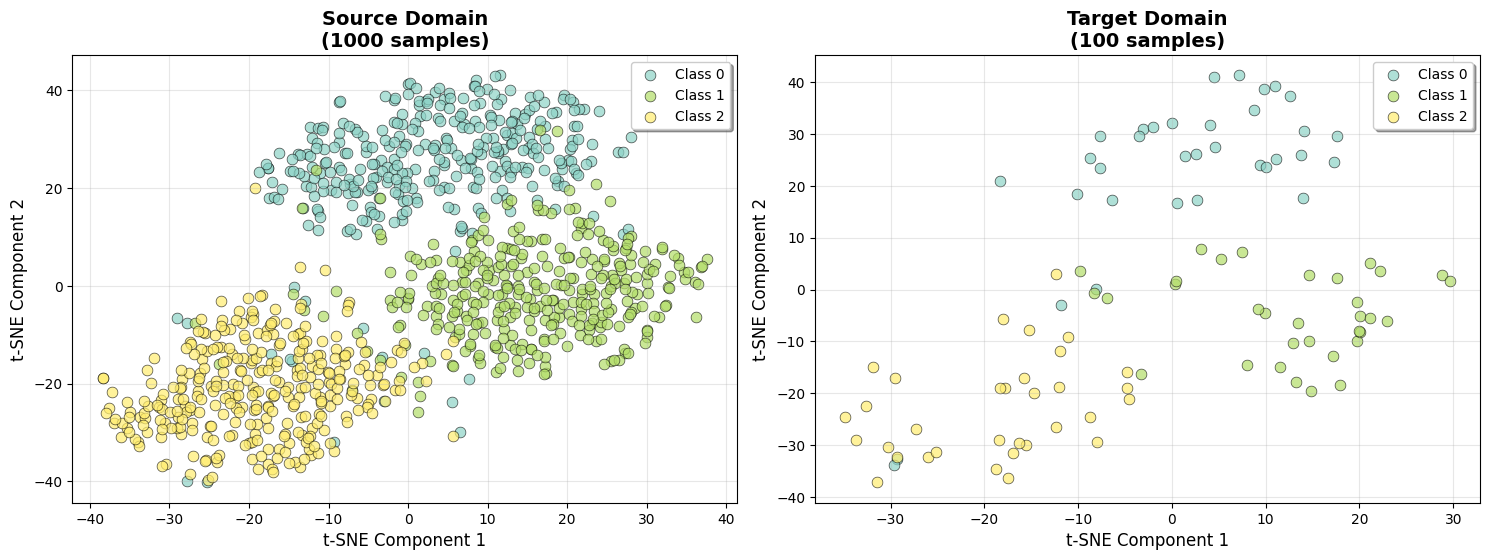

In [30]:
gendata.visualby_tsne(xs_hat, xt_hat, Ys, Yt)

In [31]:
x_comb = np.vstack((xs_hat, xt_hat))
comb_cluster_labels, model2 = clustering(x_comb)
ari = adjusted_rand_score(Yt, comb_cluster_labels[ns:])
print(f'Adjusted Rand Index (ARI) of target on transported domain: {ari:.4f}')

Adjusted Rand Index (ARI) of target on transported domain: 0.9109
